# An Analysis of Climate Change: Examining GHG Emissions and Their Effects

#### Data sourced from:
- [Berkeley Earth, Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)
    - "We have repackaged the data from a newer compilation put together by the Berkeley Earth, which is affiliated with Lawrence Berkeley National Laboratory. The Berkeley Earth Surface Temperature Study combines 1.6 billion temperature reports from 16 pre-existing archives. It is nicely packaged and allows for slicing into interesting subsets (for example by country). They publish the source data and the code for the transformations they applied. They also use methods that allow weather observations from shorter time series to be included, meaning fewer observations need to be thrown away."
    
- [UN, GHG Inventory, Kaggle](https://www.kaggle.com/unitednations/international-greenhouse-gas-emissions)
    - "The Greenhouse Gas (GHG) Inventory Data contains the most recently submitted information, covering the period from 1990 to the latest available year, to the extent the data have been provided. The GHG data contain information on anthropogenic emissions by sources and removals by sinks of the following GHGs (carbon dioxide (CO2), methane (CH4), nitrous oxide (N2O), hydrofluorocarbons (HFCs), perfluorocarbons (PFCs), unspecified mix of HFCs and PFCs, sulphur hexafluoride (SF6) and nitrogen triflouride (NF3)) that are not controlled by the Montreal Protocol."
    
    

- ARIMA gridsearch functions sourced from:
    - [Machine Learning Mastery](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)



### 1. Importing Necessary Libraries 

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas import DataFrame
from pandas import Grouper
import seaborn as sns
%matplotlib inline
from darts import TimeSeries
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.statespace.tools import diff as diff
import altair as alt

from pandas.plotting import lag_plot
from matplotlib.pylab import rcParams
from matplotlib import pyplot
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from darts.models import AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from pandas import datetime

from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from scipy.stats import jarque_bera as jb
from darts.models import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from numpy import log


import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode


warnings.filterwarnings("ignore")
#import fbprophet
#from prophet import Prophet

#print('Prophet %s' % fbprophet.__version__)


## 2. Importing and Inspecting Berkeley Country Temp Dataset 

In [113]:
df=pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [114]:
US = ['United States']

In [115]:
df=df[df.Country.isin(US)]

In [116]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,2.880,United States
554881,1768-10-01,8.162,3.386,United States
554882,1768-11-01,1.591,3.783,United States
554883,1768-12-01,-2.882,4.979,United States
554884,1769-01-01,-3.952,4.856,United States


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2941 entries, 554880 to 557820
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2941 non-null   object 
 1   AverageTemperature             2482 non-null   float64
 2   AverageTemperatureUncertainty  2482 non-null   float64
 3   Country                        2941 non-null   object 
dtypes: float64(2), object(2)
memory usage: 114.9+ KB


###### Converting temperature to fahrenheit

In [118]:
df['AverageTemperature']=df['AverageTemperature'].apply(lambda x: x * 1.8 + 32)

###### Converting 'dt' to Datetime

In [119]:
df['dt']=pd.to_datetime(df['dt'])

###### Checking for missing values

In [120]:
df.isnull().sum()

dt                                 0
AverageTemperature               459
AverageTemperatureUncertainty    459
Country                            0
dtype: int64

In [121]:
df.dropna()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,59.7560,2.880,United States
554881,1768-10-01,46.6916,3.386,United States
554882,1768-11-01,34.8638,3.783,United States
554883,1768-12-01,26.8124,4.979,United States
554884,1769-01-01,24.8864,4.856,United States
...,...,...,...,...
557816,2013-05-01,57.3314,0.178,United States
557817,2013-06-01,68.3564,0.236,United States
557818,2013-07-01,71.7332,0.152,United States
557819,2013-08-01,70.1024,0.249,United States


###### Pivoting DF for time series analysis 

In [122]:
df = pd.pivot_table(df, values='AverageTemperature', index='dt',
                    columns=['Country'])
df.head()

Country,United States
dt,
1768-09-01,59.7560
1768-10-01,46.6916
1768-11-01,34.8638
1768-12-01,26.8124
1769-01-01,24.8864


###### Checking status of  DF

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2482 entries, 1768-09-01 to 2013-09-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   United States  2482 non-null   float64
dtypes: float64(1)
memory usage: 38.8 KB


In [124]:
df.isnull().sum()

Country
United States    0
dtype: int64

In [125]:
print(df.head())
print(df.tail)

Country     United States
dt                       
1768-09-01        59.7560
1768-10-01        46.6916
1768-11-01        34.8638
1768-12-01        26.8124
1769-01-01        24.8864
<bound method NDFrame.tail of Country     United States
dt                       
1768-09-01        59.7560
1768-10-01        46.6916
1768-11-01        34.8638
1768-12-01        26.8124
1769-01-01        24.8864
...                   ...
2013-05-01        57.3314
2013-06-01        68.3564
2013-07-01        71.7332
2013-08-01        70.1024
2013-09-01        64.8914

[2482 rows x 1 columns]>


In [126]:
df.describe()

Country,United States
count,2482.000000
mean,47.486431
std,16.156996
min,18.354200
25%,32.461250
50%,47.415200
75%,63.114800
max,73.414400


## 3. Initial Plotting, EDA and Analysis of USA Land Temp

Text(0.5, 1.0, 'Changing USA Land Temp by Month (1768 - 2013)')

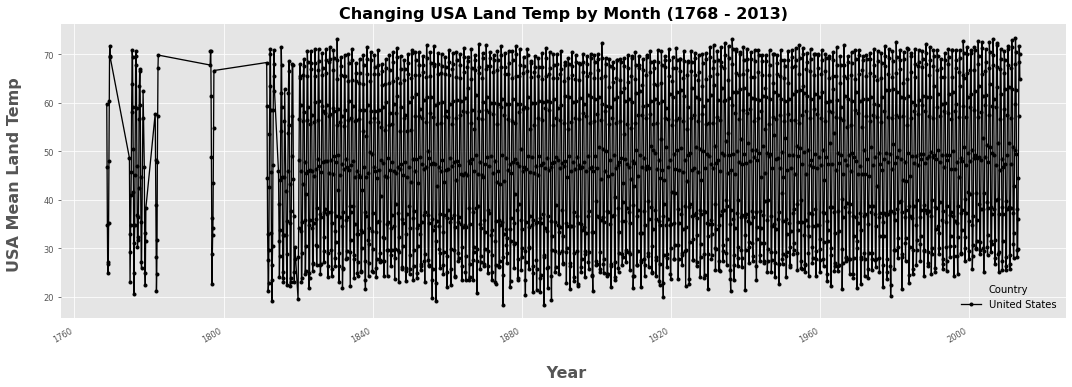

In [127]:
df.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Changing USA Land Temp by Month (1768 - 2013)", fontsize = 16, fontweight = "bold")


###### Resampling time series to year to ease analysis

In [128]:
df = df.resample('A').mean()

Text(0.5, 1.0, 'Changing USA Land Temp by Year (1768 - 2013)')

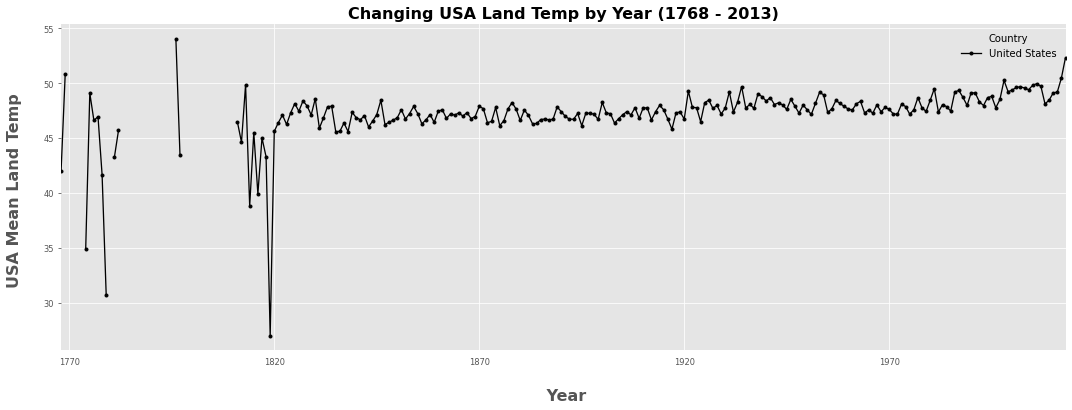

In [129]:
df.plot(figsize = (18,6), style='.k-')

plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Changing USA Land Temp by Year (1768 - 2013)", fontsize = 16, fontweight = "bold")


###### Examining series using MissingValuesFiller 

In [130]:
incomplete_series = TimeSeries.from_dataframe(df)

Text(0.5, 1.0, 'Changing USA Land Temp by Year (1768 - 2013)')

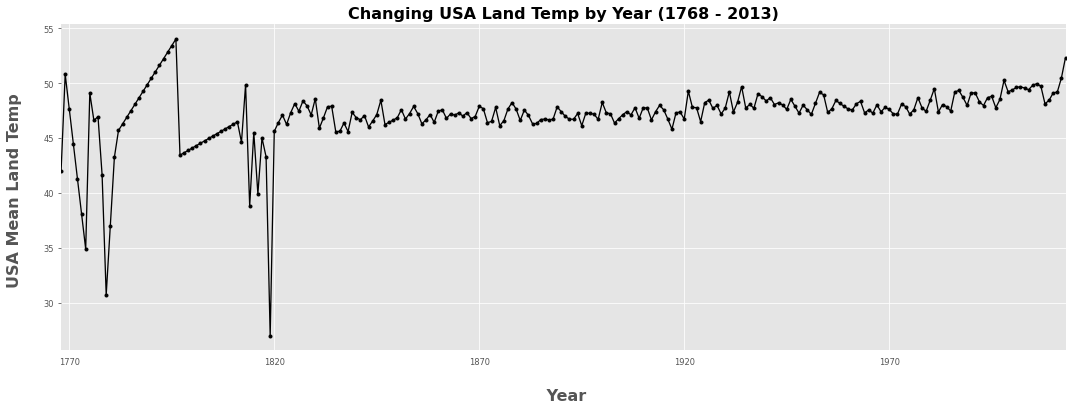

In [131]:
filler = MissingValuesFiller()
filled = filler.transform(incomplete_series, method='time')

filled.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Changing USA Land Temp by Year (1768 - 2013)", fontsize = 16, fontweight = "bold")

#### Setting a new start year (1820) given our missing values
    - Given the amount of missing years, Ffill, Bfill and Missing Values Filler cannot accurately predict temperature

Text(0.5, 1.0, 'Changing USA Land Temp by Year (1820 - 2013)')

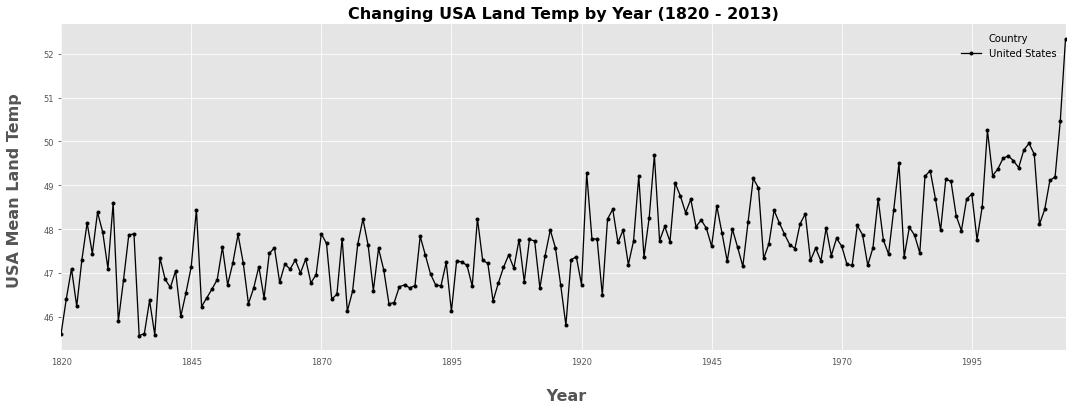

In [132]:
df_1820on= df['1820':]
df_1820on.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Changing USA Land Temp by Year (1820 - 2013)", fontsize = 16, fontweight = "bold")

##### Examining trends over the last 50 years 

Text(0.5, 1.0, 'Changing USA Land Temp by Year (1970 - 2013)')

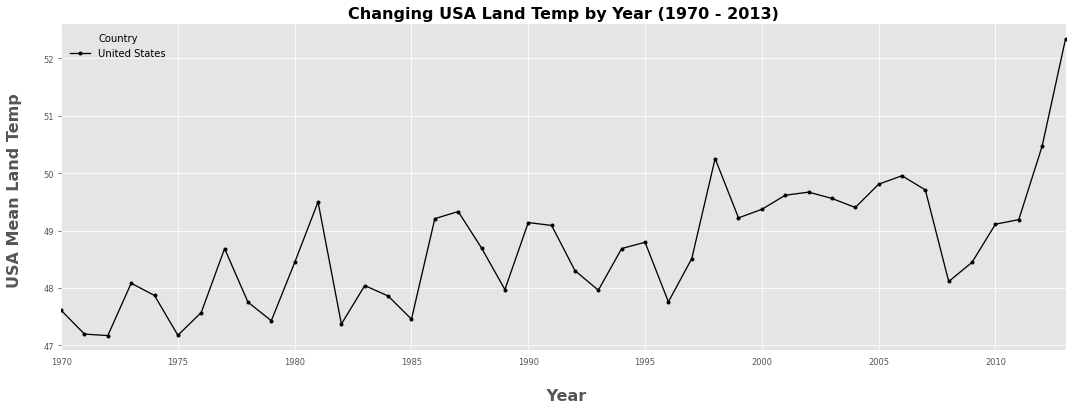

In [133]:
df_1970on = df['1970':]
df_1970on.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Changing USA Land Temp by Year (1970 - 2013)", fontsize = 16, fontweight = "bold")

Mean is: Country
United States    47.658005
dtype: float64


Text(0.5, 1.0, 'Rolling Mean Temp for USA (1970 - 2013)')

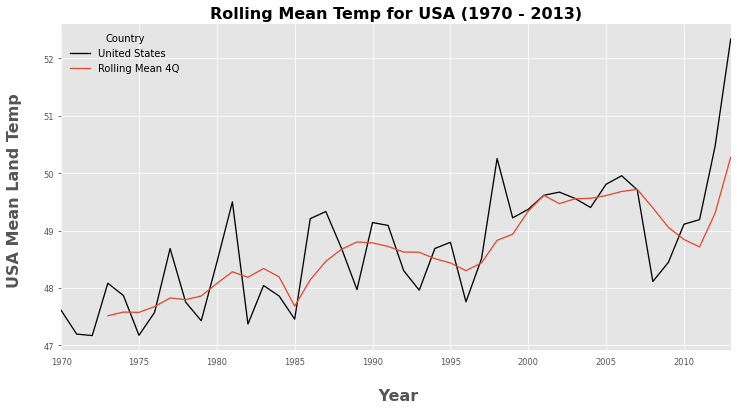

In [134]:
df_1970on.plot(figsize=(12,6), legend=True, label="Train", cmap='gray')
df_1970on['United States'].rolling(4, center=False).mean().plot(legend=True, label="Rolling Mean 4Q");
print("Mean is:", df_1820on.mean())
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Rolling Mean Temp for USA (1970 - 2013)", fontsize = 16, fontweight = "bold")

##### Examining trends from 2000 on

Text(0.5, 1.0, 'Changing USA Land Temp by Year (2000 - 2013)')

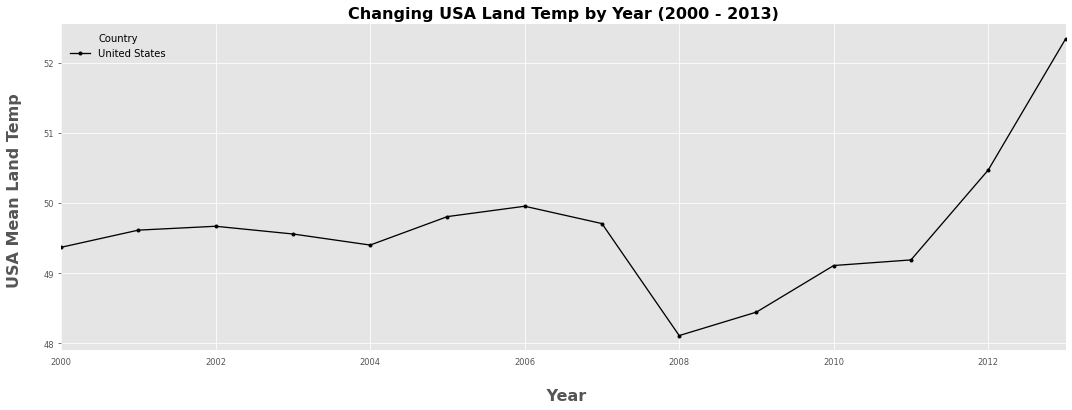

In [135]:
df_2000on = df['2000':]
df_2000on.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("USA Mean Land Temp \n", fontsize = 16, fontweight = "bold")
plt.title("Changing USA Land Temp by Year (2000 - 2013)", fontsize = 16, fontweight = "bold")

#### There is a drastic dropoff in in temperature in 2008. Per the National Climate Report for 2008, "... the  the contiguous U.S. experienced a nationally averaged temperature that was the coolest in more than ten years." 

     2008 was notable for the North American Blizzard of 2008 and a strong Nor'easter in the spring. 

## 4. Stationary Tests and Prep for Modeling

##### Using Augmented Dickey-Fuller test to check if our time series is stationary 

Text(0.5, 1.0, 'Autocorrelation Plot for USA Mean Land Temp (1820-2013)')

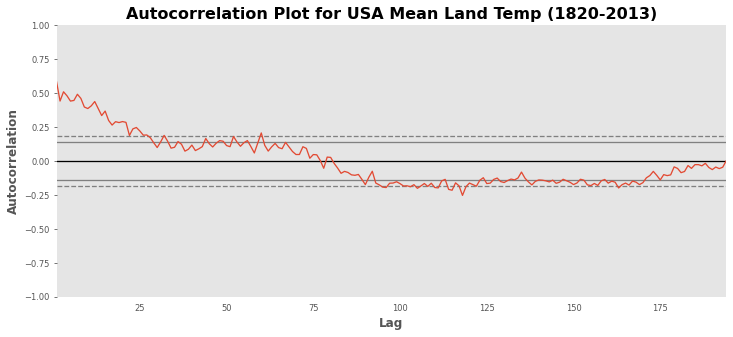

In [136]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(df_1820on);

plt.title("Autocorrelation Plot for USA Mean Land Temp (1820-2013)", fontsize = 16, fontweight = "bold")

##### From appearances alone, our time series is non-stationary. Regardless, we'll check our p-value. 


In [137]:
adf = adfuller(df_1820on["United States"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.9308 , Series is Non-Stationary


#### Time series is non-stationary. Let's examine detrending using .diff(). 

p value:7.54095038137151e-15 , Series is Stationary


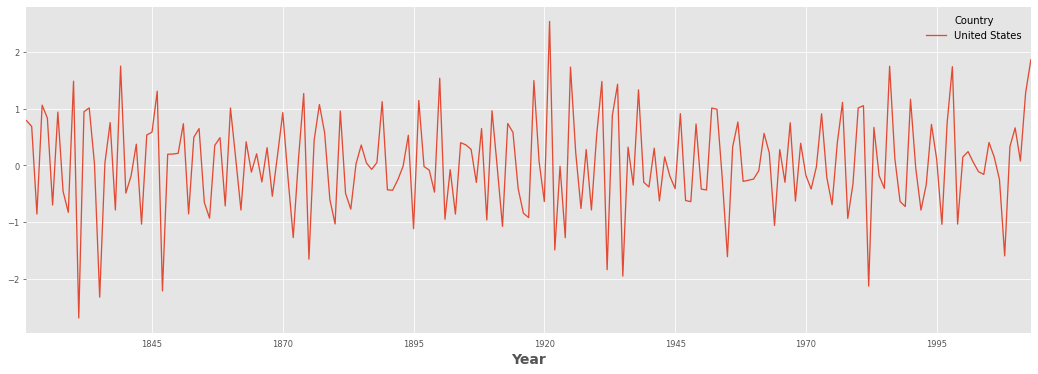

In [138]:
de_trended_1820 = df_1820on.diff(1).dropna()
adf2 = adfuller(de_trended_1820)[1]
print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
de_trended_1820.plot(figsize=(18,6))
plt.xlabel('Year', fontsize=14);

#### After differencing by 1 year, our time series is now stationary. 


Text(0.5, 1.0, 'Autocorrelation Plot for USA Mean Land Temp (1820-2013), Stationary')

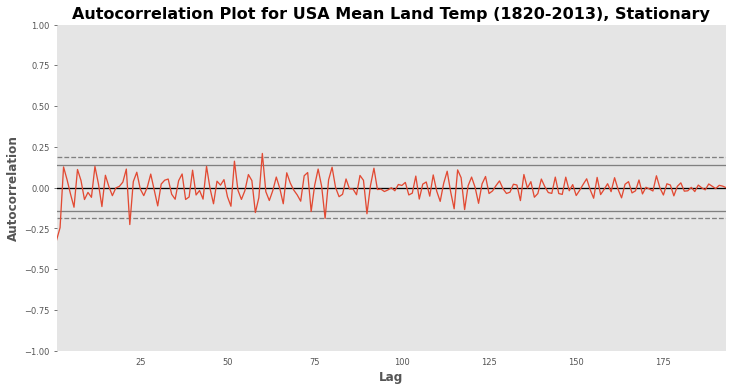

In [139]:
plt.figure(figsize=(12,6))
pd.plotting.autocorrelation_plot(de_trended_1820)
plt.title("Autocorrelation Plot for USA Mean Land Temp (1820-2013), Stationary", fontsize = 16, fontweight = "bold")

In [140]:
#Making a copy of our de-trended 1820 time series
dfDT = de_trended_1820.copy()

Text(0.5, 1.0, 'Autocorrelation Plot for USA Mean Land Temp (1820-2013), Non-Stationary')

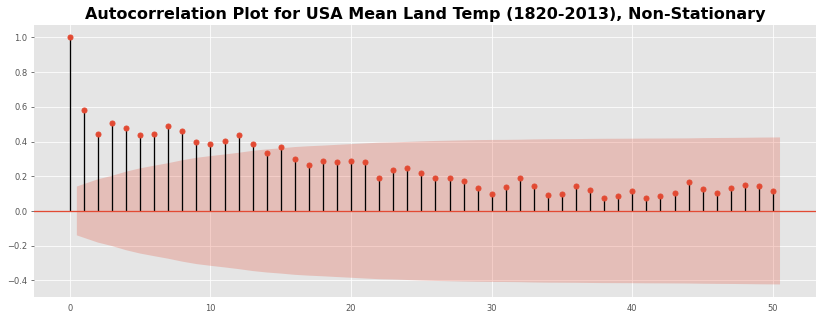

In [141]:
rcParams['figure.figsize'] = 14, 5

plot_acf(df_1820on, lags=50);
plt.title("Autocorrelation Plot for USA Mean Land Temp (1820-2013), Non-Stationary", fontsize = 16, fontweight = "bold")

Text(0.5, 1.0, 'Autocorrelation Plot for USA Mean Land Temp (1820-2013), Stationary')

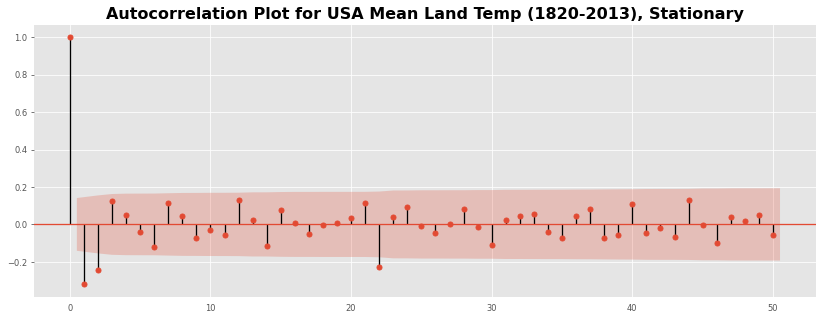

In [142]:
rcParams['figure.figsize'] = 14, 5

plot_acf(dfDT, lags=50);
plt.title("Autocorrelation Plot for USA Mean Land Temp (1820-2013), Stationary", fontsize = 16, fontweight = "bold")

Text(0.5, 1.0, 'Partial Autocorrelation Plot for USA Mean Land Temp (1820-2013), Stationary')

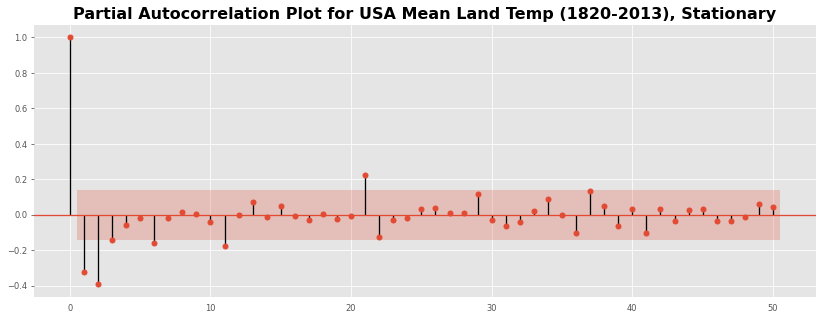

In [143]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(dfDT, lags=50);
plt.title("Partial Autocorrelation Plot for USA Mean Land Temp (1820-2013), Stationary", fontsize = 16, fontweight = "bold")

## 5. ARIMA Modeling for USA Average Land Temp 

##### As our time series is already differenced by 1 year, we'll leave 'd' at 0. 
##### Given our autocorrelation and partial autocorrelation plots, we'll start baseline testing with 'p' and 'q' at 1. 


In [213]:
model = ARIMA(dfDT, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          United States   No. Observations:                  193
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -210.144
Date:                Thu, 29 Apr 2021   AIC                            428.287
Time:                        14:43:18   BIC                            441.338
Sample:                    12-31-1821   HQIC                           433.572
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0158      0.008      1.871      0.061      -0.001       0.032
ar.L1          0.1744      0.093      1.866      0.062      -0.009       0.358
ma.L1         -0.8799      0.053    -16.475      0.0

#### Our P values look decent, let's try other combinations before further testing and deciding on a set model. 

In [145]:
modelA = ARIMA(dfDT, order=(1,0,3))
model_fitA = modelA.fit()
print(model_fitA.summary())

                               SARIMAX Results                                
Dep. Variable:          United States   No. Observations:                  193
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -207.060
Date:                Thu, 29 Apr 2021   AIC                            426.120
Time:                        12:04:54   BIC                            445.696
Sample:                    12-31-1821   HQIC                           434.048
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0159      0.009      1.780      0.075      -0.002       0.033
ar.L1         -0.1936      0.458     -0.423      0.672      -1.091       0.704
ma.L1         -0.4767      0.456     -1.045      0.2

In [146]:
modelB = ARIMA(dfDT, order=(0,0,1))
model_fitB = modelB.fit()
print(model_fitB.summary())

                               SARIMAX Results                                
Dep. Variable:          United States   No. Observations:                  193
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -212.171
Date:                Thu, 29 Apr 2021   AIC                            430.342
Time:                        12:04:55   BIC                            440.130
Sample:                    12-31-1821   HQIC                           434.306
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.009      1.742      0.082      -0.002       0.035
ma.L1         -0.8354      0.046    -18.088      0.000      -0.926      -0.745
sigma2         0.5244      0.045     11.603      0.0

In [147]:
print(dfDT.head)
print(dfDT.tail)

<bound method NDFrame.head of Country     United States
dt                       
1821-12-31        0.79245
1822-12-31        0.68895
1823-12-31       -0.85650
1824-12-31        1.06425
1825-12-31        0.83565
...                   ...
2009-12-31        0.33420
2010-12-31        0.66330
2011-12-31        0.07980
2012-12-31        1.28010
2013-12-31        1.86485

[193 rows x 1 columns]>
<bound method NDFrame.tail of Country     United States
dt                       
1821-12-31        0.79245
1822-12-31        0.68895
1823-12-31       -0.85650
1824-12-31        1.06425
1825-12-31        0.83565
...                   ...
2009-12-31        0.33420
2010-12-31        0.66330
2011-12-31        0.07980
2012-12-31        1.28010
2013-12-31        1.86485

[193 rows x 1 columns]>


##### Checking prediction and MSE on our first model (ARIMA order: 1,0,1)

MSE:  0.5178917093478309


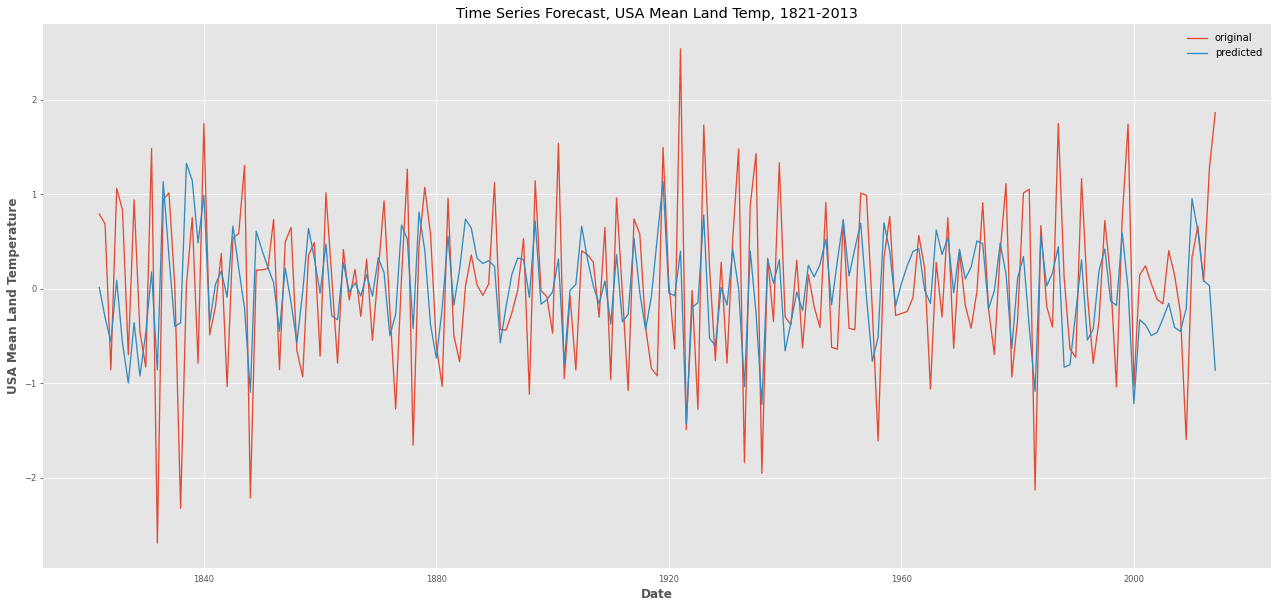

In [148]:
# Setting index for analysis
start_index = datetime(1821, 12, 31)
end_index = datetime(2013, 12, 31)
forecast = model_fit.predict(start=start_index, end=end_index)

error = mean_squared_error(dfDT, forecast)
print("MSE: " ,error)
# Plotting
plt.figure(figsize=(22,10))
plt.plot(dfDT,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast, USA Mean Land Temp, 1821-2013")
plt.xlabel("Date")
plt.ylabel("USA Mean Land Temperature")
plt.legend()
plt.savefig('graph.png')

plt.show()

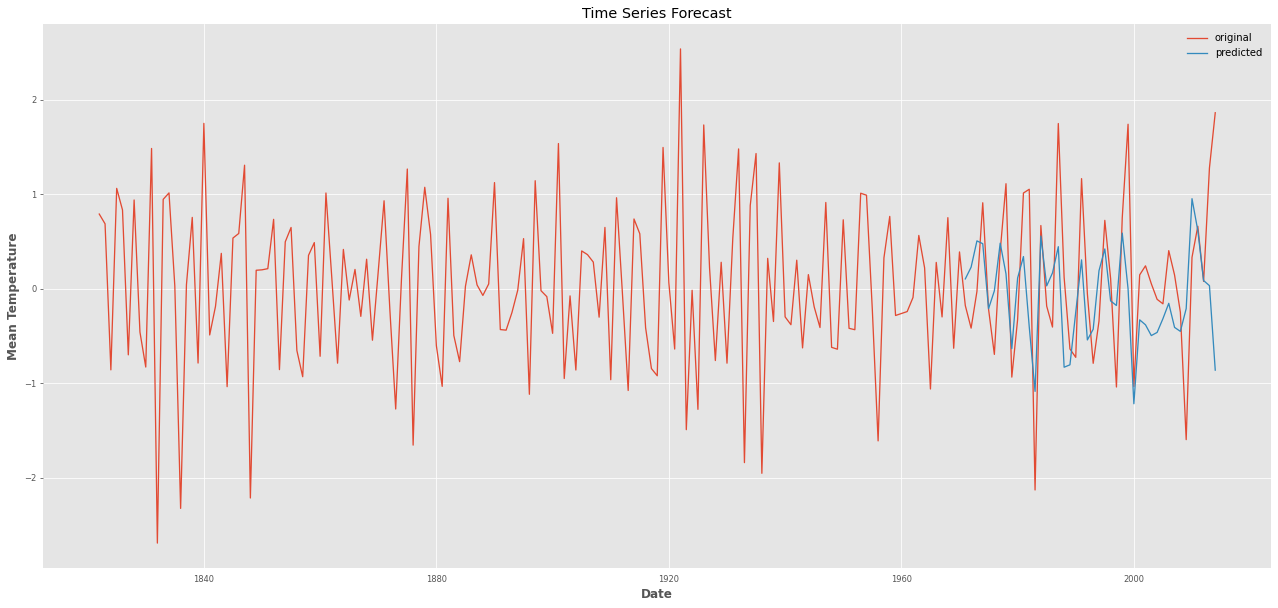

In [149]:
# Setting index for analysis 
start_index = datetime(1970, 12, 31)
end_index = datetime(2013, 12, 31)
forecast = model_fit.predict(start=start_index, end=end_index)

# Plotting
plt.figure(figsize=(22,10))
plt.plot(dfDT,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

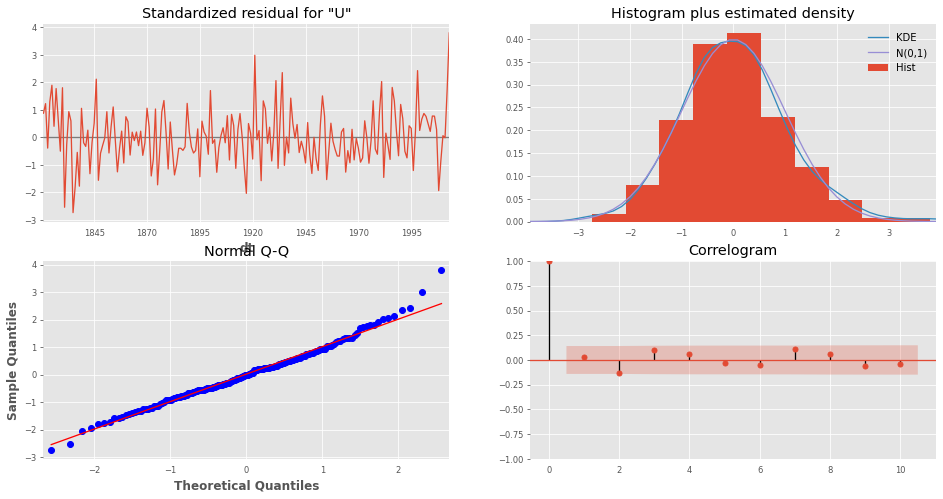

In [150]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

##### Per our residuals and density, we can state we've accounted for most seasonality and trends. Our model residuals seem to be evenly distributed.
    - Next, we'll use Auto-ARIMA and gridsearch for the best possible ARIMA order and AIC score. 

In [151]:
mean_squared_error(dfDT, model_fit.predict())

0.5178917093478309

In [152]:
series = TimeSeries.from_dataframe(dfDT)

In [153]:
arima_model = auto_arima(dfDT, start_p=0, d=None, start_q=0, max_p=6, max_d=5, max_q=5,
                        m=1, seasonal=False, error_action='warn',
                        trace=True, suprress_warnings=True, stepwise=True, random_state=20,
                        n_fits=50)

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=496.641, BIC=503.167, Time=0.052 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=477.150, BIC=486.939, Time=0.041 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=430.342, BIC=440.130, Time=0.045 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=494.952, BIC=498.215, Time=0.015 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=428.287, BIC=441.338, Time=0.068 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=425.662, BIC=441.976, Time=0.092 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=443.546, BIC=456.597, Time=0.036 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=425.869, BIC=445.445, Time=0.147 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=426.046, BIC=445.622, Time=0.269 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=424.607, BIC=440.920, Time=0.115 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=426.092

In [154]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  193
Model:               SARIMAX(0, 0, 3)   Log Likelihood                -207.145
Date:                Thu, 29 Apr 2021   AIC                            424.290
Time:                        12:04:58   BIC                            440.604
Sample:                             0   HQIC                           430.897
                                - 193                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0159      0.009      1.759      0.079      -0.002       0.034
ma.L1         -0.6662      0.070     -9.488      0.000      -0.804      -0.529
ma.L2         -0.3158      0.100     -3.165      0.002      -0.511      -0.120
ma.L3          0.1437      0.089      1.623      0.105      -0.030       0.317
sigma2         0.4976      0.045     11.060      0.000       0.409       0.586
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               0.90   Skew:                             0.31
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
model2 = ARIMA(dfDT, order=(0,0,3))
model_fit2 = model2.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          United States   No. Observations:                  193
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -210.144
Date:                Thu, 29 Apr 2021   AIC                            428.287
Time:                        12:04:58   BIC                            441.338
Sample:                    12-31-1821   HQIC                           433.572
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0158      0.008      1.871      0.061      -0.001       0.032
ar.L1          0.1744      0.093      1.866      0.062      -0.009       0.358
ma.L1         -0.8799      0.053    -16.475      0.0

##### Our Auto-ARIMA has given us an order of 0,0,3, let's examine predicted values and MSE. 

MSE:  0.5019500858000303


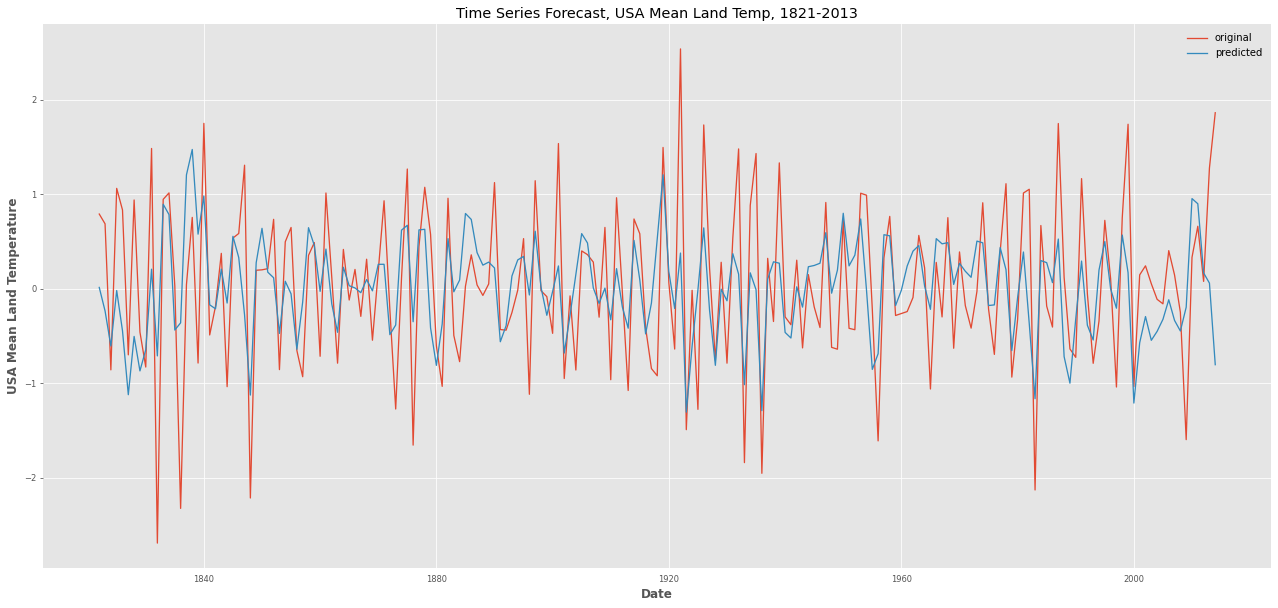

In [156]:
# Setting index for analysis
start_index = datetime(1821, 12, 31)
end_index = datetime(2013, 12, 31)
forecast = model_fit2.predict(start=start_index, end=end_index)

error = mean_squared_error(dfDT, forecast)
print("MSE: " ,error)
# Plotting
plt.figure(figsize=(22,10))
plt.plot(dfDT,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast, USA Mean Land Temp, 1821-2013")
plt.xlabel("Date")
plt.ylabel("USA Mean Land Temperature")
plt.legend()
plt.savefig('graph.png')

plt.show()

### Our US ARIMA model using Auto-ARIMA is performing marginally better than our original model: 
    - Our MSE is now: 0.502
    - Our AIC is: 428.29
    - Our P values are all below .05
    
### Before moving on, let's try a train/test split (70/30) and let ARIMA difference the dataset. 

In [211]:
arima_modelB = auto_arima(df_1820on, start_p=0, d=1, start_q=0, max_p=6, max_d=5, max_q=15,
                        m=1, seasonal=False, error_action='warn',
                        trace=True, suprress_warnings=True, stepwise=True, random_state=20,
                        n_fits=50)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=496.641, BIC=503.167, Time=0.049 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=477.150, BIC=486.939, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=430.342, BIC=440.130, Time=0.065 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=494.952, BIC=498.215, Time=0.010 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=428.287, BIC=441.338, Time=0.064 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=425.663, BIC=441.976, Time=0.101 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=443.546, BIC=456.597, Time=0.026 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=425.869, BIC=445.445, Time=0.117 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=426.046, BIC=445.622, Time=0.211 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=424.607, BIC=440.920, Time=0.097 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=426.092

In [158]:
arima_modelB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  194
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -207.145
Date:                Thu, 29 Apr 2021   AIC                            424.290
Time:                        12:05:00   BIC                            440.604
Sample:                             0   HQIC                           430.897
                                - 194                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0159      0.009      1.759      0.079      -0.002       0.034
ma.L1         -0.6662      0.070     -9.488      0.000      -0.804      -0.529
ma.L2         -0.3158      0.100     -3.165      0.002      -0.511      -0.120
ma.L3          0.1437      0.089      1.623      0.105      -0.030       0.317
sigma2         0.4976      0.045     11.060      0.000       0.409       0.586
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               0.90   Skew:                             0.31
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Let's visualize our train/test approach to the data and check scores.

predicted=48.146084, expected=47.330900
predicted=47.866975, expected=47.659850
predicted=48.099520, expected=48.427400
predicted=48.139057, expected=48.146300
predicted=48.035031, expected=47.885600
predicted=48.035066, expected=47.646050
predicted=47.974709, expected=47.555600
predicted=47.946756, expected=48.121700
predicted=48.050377, expected=48.344000
predicted=48.030065, expected=47.285000
predicted=47.786997, expected=47.565800
predicted=47.957986, expected=47.269400
predicted=47.741096, expected=48.023600
predicted=47.958485, expected=47.395850
predicted=47.664664, expected=47.787500
predicted=47.861278, expected=47.611400
predicted=47.705144, expected=47.196500
predicted=47.646221, expected=47.170550
predicted=47.611333, expected=48.082400
predicted=47.788373, expected=47.868650
predicted=47.641717, expected=47.175800
predicted=47.557178, expected=47.572250
predicted=47.682577, expected=48.685700
predicted=47.879854, expected=47.752550
predicted=47.600481, expected=47.428850


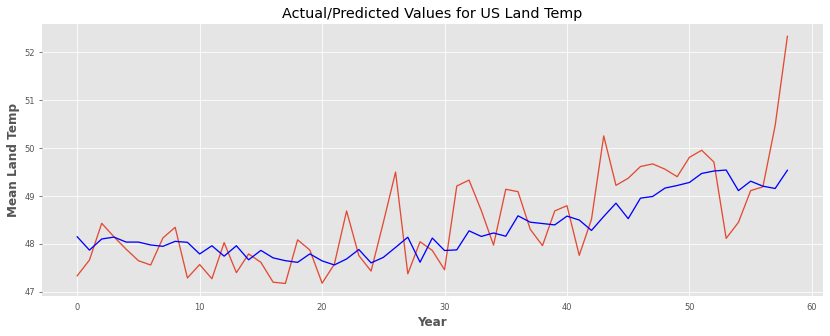

In [159]:
X = df_1820on.values
size = int(len(X) * .7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='blue')
pyplot.title('Actual/Predicted Values for US Land Temp')
pyplot.ylabel('Mean Land Temp')
pyplot.xlabel('Year')
pyplot.show()

#### Our data still needs some work predicting, but our RMSE is very low. 

In [160]:
model3 = ARIMA(df_1820on, order=(0,1,3))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:          United States   No. Observations:                  194
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -208.719
Date:                Thu, 29 Apr 2021   AIC                            425.438
Time:                        12:05:04   BIC                            438.489
Sample:                    12-31-1820   HQIC                           430.723
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6522      0.070     -9.301      0.000      -0.790      -0.515
ma.L2         -0.3103      0.099     -3.148      0.002      -0.504      -0.117
ma.L3          0.1505      0.088      1.716      0.0

In [161]:
mean_squared_error(df_1820on, model_fit3.predict())

11.232838724156837

### US ARIMA Conclusion
##### Regardless of our approach to the dataset, whether any data is held for training, our models are performing where we want them to be: 
    - Constant AIC scores in the low 400s. 
    - Near constant P values below .05
    - Low MSE and RMSE values across the board. 
    

## 6. Importing and Inspecting the UN's GHGS Data

In [162]:
df2 = pd.read_csv('greenhouse_gas_inventory_data_data.csv')

In [163]:
print(df2.head())
print(df2.tail())

  country_or_area  year          value  \
0       Australia  2014  393126.946994   
1       Australia  2013  396913.936530   
2       Australia  2012  406462.847704   
3       Australia  2011  403705.528314   
4       Australia  2010  406200.993184   

                                            category  
0  carbon_dioxide_co2_emissions_without_land_use_...  
1  carbon_dioxide_co2_emissions_without_land_use_...  
2  carbon_dioxide_co2_emissions_without_land_use_...  
3  carbon_dioxide_co2_emissions_without_land_use_...  
4  carbon_dioxide_co2_emissions_without_land_use_...  
               country_or_area  year       value  \
8401  United States of America  1994  593.222570   
8402  United States of America  1993  586.939752   
8403  United States of America  1992  574.414624   
8404  United States of America  1991  566.900968   
8405  United States of America  1990  293.205663   

                                               category  
8401  unspecified_mix_of_hydrofluorocarbons_hf

In [164]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_or_area  8406 non-null   object 
 1   year             8406 non-null   int64  
 2   value            8406 non-null   float64
 3   category         8406 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 262.8+ KB


In [165]:
df2.describe()

,year,value
count,8406.000000,8.406000e+03
mean,2002.188437,2.055472e+05
std,7.151605,8.041504e+05
min,1990.000000,1.103750e-06
25%,1996.000000,2.976980e+02
50%,2002.000000,7.840318e+03
75%,2008.000000,6.589885e+04
max,2014.000000,7.422208e+06


##### Checking for missing data

In [166]:
df2.isnull().sum()

country_or_area    0
year               0
value              0
category           0
dtype: int64

##### Converting year to date time

In [167]:
df2.year = pd.to_datetime(df2.year, format='%Y')

##### Selecting USA from countries 

In [168]:
USA = ['United States of America']

In [169]:
df2=df2[df2.country_or_area.isin(USA)]
df2.head()

,country_or_area,year,value,category
1049,United States of America,2014-01-01,5.556007e+06,carbon_dioxide_co2_emissions_without_land_use_...
1050,United States of America,2013-01-01,5.502551e+06,carbon_dioxide_co2_emissions_without_land_use_...
1051,United States of America,2012-01-01,5.349221e+06,carbon_dioxide_co2_emissions_without_land_use_...
1052,United States of America,2011-01-01,5.559508e+06,carbon_dioxide_co2_emissions_without_land_use_...
1053,United States of America,2010-01-01,5.688756e+06,carbon_dioxide_co2_emissions_without_land_use_...


In [170]:
df2 = df2.rename(columns={"country_or_area": "USA"})
df2.head()

,USA,year,value,category
1049,United States of America,2014-01-01,5.556007e+06,carbon_dioxide_co2_emissions_without_land_use_...
1050,United States of America,2013-01-01,5.502551e+06,carbon_dioxide_co2_emissions_without_land_use_...
1051,United States of America,2012-01-01,5.349221e+06,carbon_dioxide_co2_emissions_without_land_use_...
1052,United States of America,2011-01-01,5.559508e+06,carbon_dioxide_co2_emissions_without_land_use_...
1053,United States of America,2010-01-01,5.688756e+06,carbon_dioxide_co2_emissions_without_land_use_...


##### Inspecting and modifying different emissions types 

In [171]:
df2['category'].value_counts()

carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent     25
sulphur_hexafluoride_sf6_emissions_in_kilotonne_co2_equivalent                                                    25
hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent                                                     25
perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent                                                       25
nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent      25
unspecified_mix_of_hydrofluorocarbons_hfcs_and_perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent        25
methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent            25
greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent    25
greenhouse_gas_ghgs_emissions_including_indirect_co2_without_lul

In [172]:
GHG = ['carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent',
      'greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent']

##### Creating a copy to select best indicator of US emissions

In [173]:
df2a = df2.copy()

In [174]:
df2a=df2a[df2a.category.isin(GHG)]
df2a.head()

,USA,year,value,category
1049,United States of America,2014-01-01,5.556007e+06,carbon_dioxide_co2_emissions_without_land_use_...
1050,United States of America,2013-01-01,5.502551e+06,carbon_dioxide_co2_emissions_without_land_use_...
1051,United States of America,2012-01-01,5.349221e+06,carbon_dioxide_co2_emissions_without_land_use_...
1052,United States of America,2011-01-01,5.559508e+06,carbon_dioxide_co2_emissions_without_land_use_...
1053,United States of America,2010-01-01,5.688756e+06,carbon_dioxide_co2_emissions_without_land_use_...


##### Pivoting DF for analysis

In [175]:
df2a = pd.pivot_table(df2a, values='value', index='year',
                    columns=['USA', 'category'])
df2a.head()

USA                                                                                             United States of America  \
category   carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent   
year                                                                                                                       
1990-01-01                                       5.115095e+06                                                              
1991-01-01                                       5.064880e+06                                                              
1992-01-01                                       5.170274e+06                                                              
1993-01-01                                       5.284759e+06                                                              
1994-01-01                                       5.377492e+06                                                              

USA                                                                                                                        
category   greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent  
year                                                                                                                       
1990-01-01                                       6.397144e+06                                                              
1991-01-01                                       6.330938e+06                                                              
1992-01-01                                       6.448677e+06                                                              
1993-01-01                                       6.566416e+06                                                              
1994-01-01                                       6.650297e+06

##### Renaming columns for legibility

In [176]:
df2a.columns = ['CO2','GHGS']

In [177]:
df2a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 1990-01-01 to 2014-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     25 non-null     float64
 1   GHGS    25 non-null     float64
dtypes: float64(2)
memory usage: 600.0 bytes


##### Comparing CO2 emissions with grouped GHGS emissions

Text(0.5, 1.0, 'US GHG Emissions by Year (1990 - 2014), C02 Separated')

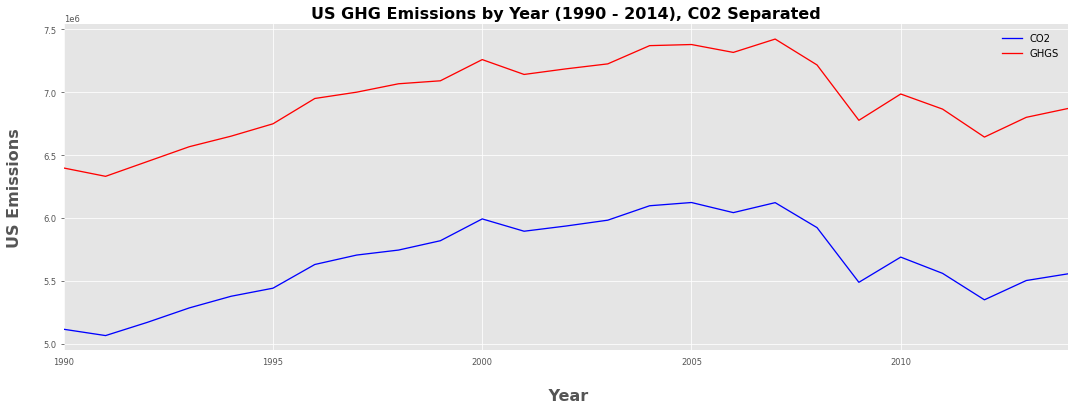

In [178]:
df2a.plot(color = ['b', 'r'],figsize = (18,6))
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("US Emissions\n", fontsize = 16, fontweight = "bold")
plt.title("US GHG Emissions by Year (1990 - 2014), C02 Separated", fontsize = 16, fontweight = "bold")

In [179]:
df2a.corr()

,CO2,GHGS
CO2,1.000000,0.997761
GHGS,0.997761,1.000000


In [180]:
df2a_diff = df2a.diff(periods=1)

Text(0.5, 1.0, 'US GHG Emissions by Year (1990 - 2014), Differenced')

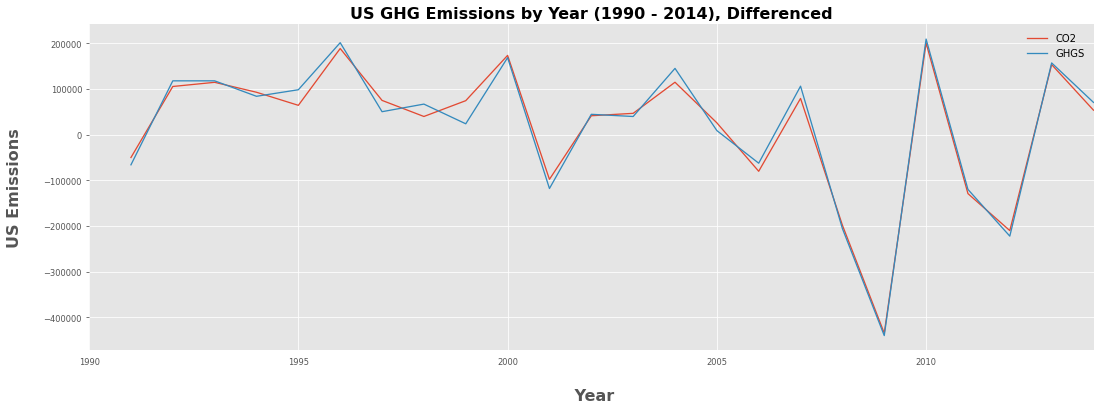

In [181]:
df2a_diff.plot(figsize=(18,6))
plt.xlabel('Year', fontsize=14);
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("US Emissions\n", fontsize = 16, fontweight = "bold")
plt.title("US GHG Emissions by Year (1990 - 2014), Differenced", fontsize = 16, fontweight = "bold")

#### Given CO2's presence in the grouped GHGS emissions and high correlation, we will be using GHGS as a marker for analysis 

In [182]:
df2 = df2[df2['category'] == 
          'greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent']

In [183]:
df2['category'].value_counts()

greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent    25
Name: category, dtype: int64

In [184]:
df2 = df2.rename(columns={"category": "Greenhouse_gas_emissions"})
df2.head()

,USA,year,value,Greenhouse_gas_emissions
3072,United States of America,2014-01-01,6.870446e+06,greenhouse_gas_ghgs_emissions_without_land_use...
3073,United States of America,2013-01-01,6.799979e+06,greenhouse_gas_ghgs_emissions_without_land_use...
3074,United States of America,2012-01-01,6.643011e+06,greenhouse_gas_ghgs_emissions_without_land_use...
3075,United States of America,2011-01-01,6.865398e+06,greenhouse_gas_ghgs_emissions_without_land_use...
3076,United States of America,2010-01-01,6.985457e+06,greenhouse_gas_ghgs_emissions_without_land_use...


###### Repeating the process from the copied DF:
    pivoting the table 
    renaming columns 
    conducting a general overview of current DF status 

In [185]:
df2 = pd.pivot_table(df2, values='value', index='year',
                    columns=['Greenhouse_gas_emissions'])
df2.head()

Greenhouse_gas_emissions,greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent
year,
1990-01-01,6.397144e+06
1991-01-01,6.330938e+06
1992-01-01,6.448677e+06
1993-01-01,6.566416e+06
1994-01-01,6.650297e+06


In [186]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 1990-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent  25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


In [187]:
df2.columns=['GHGS_USA']

Text(0.5, 1.0, 'US GHG Emissions by Year (1990 - 2014)')

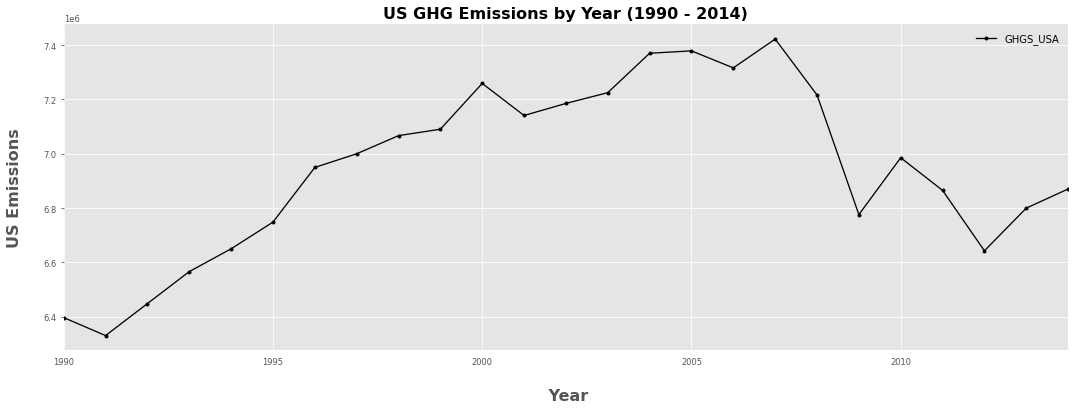

In [188]:
df2.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("US Emissions\n", fontsize = 16, fontweight = "bold")
plt.title("US GHG Emissions by Year (1990 - 2014)", fontsize = 16, fontweight = "bold")

###### Huge drop in GHGS emissions around the Great Recession of 2008. Isolating and displaying that change. 

In [189]:
df2_2005on = df2['2005':]

Text(0.5, 1.0, 'US GHG Emissions by Year (2005 - 2014)')

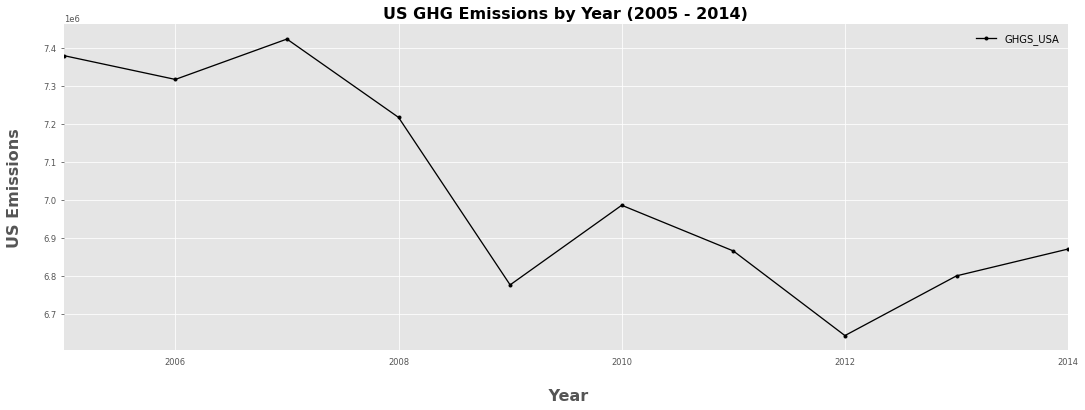

In [190]:
df2_2005on.plot(figsize = (18,6), style='.k-')
plt.xlabel("\n Year", fontsize = 16, fontweight = "bold")
plt.ylabel("US Emissions\n", fontsize = 16, fontweight = "bold")
plt.title("US GHG Emissions by Year (2005 - 2014)", fontsize = 16, fontweight = "bold")

## 7. Stationary Tests and Prep for Modeling

Text(0.5, 1.0, 'Autocorrelation Plot for US GHG Emissions (1990-2014)')

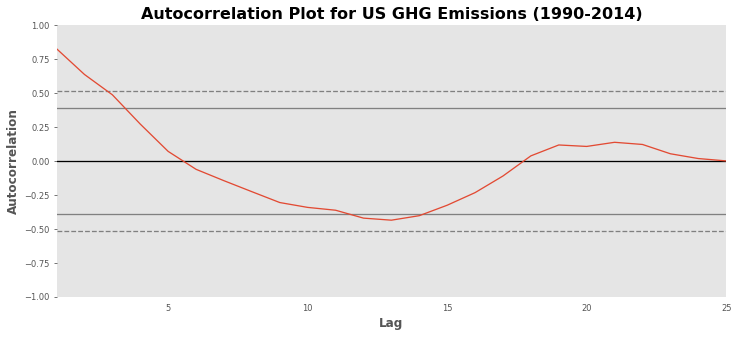

In [191]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(df2);
plt.title("Autocorrelation Plot for US GHG Emissions (1990-2014)", fontsize = 16, fontweight = "bold")

In [192]:
adf = adfuller(df2["GHGS_USA"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.5746 , Series is Non-Stationary


###### Series is currently non-stationary. WIll try differencing

p value:0.9942836713925566 , Series is Stationary


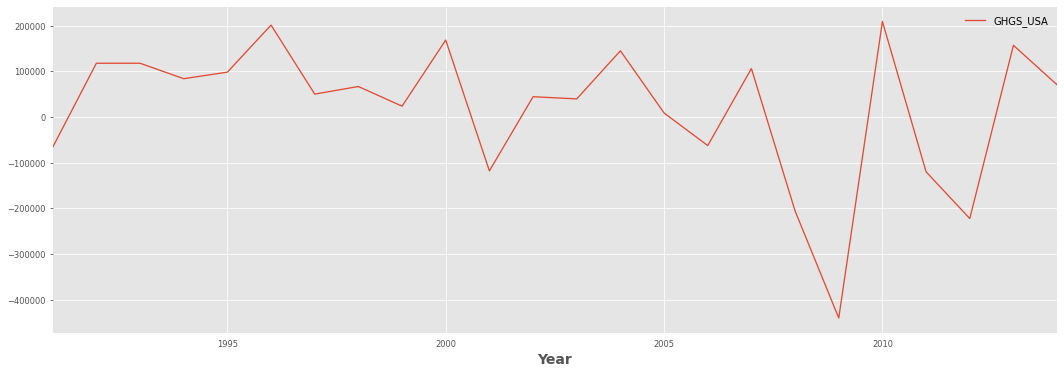

In [193]:
de_trended_df2 = df2.diff(periods=1).dropna()
adf3 = adfuller(de_trended_df2)[1]
print(f"p value:{adf3}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
de_trended_df2.plot(figsize=(18,6))
plt.xlabel('Year', fontsize=14);

Text(0.5, 1.0, 'Autocorrelation Plot for US GHG (1990-2014), Stationary')

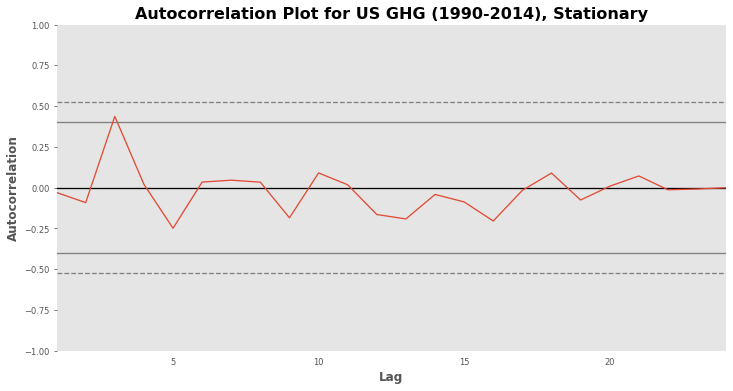

In [194]:
plt.figure(figsize=(12,6))
pd.plotting.autocorrelation_plot(de_trended_df2)
plt.title("Autocorrelation Plot for US GHG (1990-2014), Stationary", fontsize = 16, fontweight = "bold")

###### Series is now stationary! 

In [195]:
df2DT = de_trended_df2.copy()

Text(0.5, 1.0, 'Autocorrelation Plot for US GHG (1990-2014), Stationary')

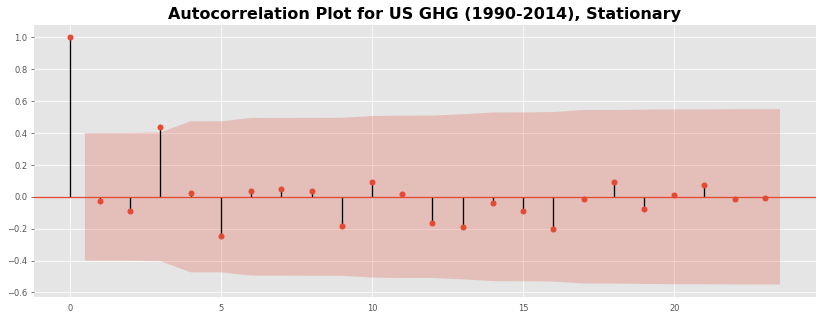

In [196]:
rcParams['figure.figsize'] = 14, 5

plot_acf(df2DT, lags=23);
plt.title("Autocorrelation Plot for US GHG (1990-2014), Stationary", fontsize = 16, fontweight = "bold")

Text(0.5, 1.0, 'Partial Autocorrelation Plot for US GHG (1990-2014), Stationary')

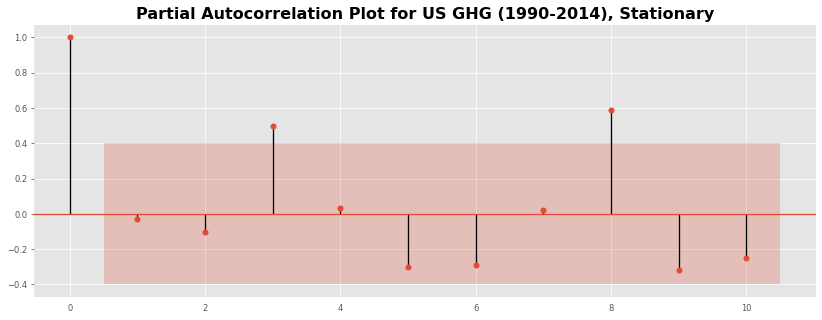

In [197]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(df2DT, lags=10);
plt.title("Partial Autocorrelation Plot for US GHG (1990-2014), Stationary", fontsize = 16, fontweight = "bold")

## 8. ARIMA Modeling for US GHGS Emissions

In [198]:
df2DT = de_trended_df2.copy()

##### As our time series is already differenced by 1 year, we'll leave 'd' at 0. 
##### Given our autocorrelation and partial autocorrelation plots, we'll start baseline testing with 'p' and 'q' at 1. 


In [199]:
model3 = ARIMA(df2DT, order=(1,0,1))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:               GHGS_USA   No. Observations:                   24
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -320.250
Date:                Thu, 29 Apr 2021   AIC                            648.500
Time:                        12:05:09   BIC                            653.212
Sample:                    01-01-1991   HQIC                           649.750
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.972e+04   3.16e+04      0.625      0.532   -4.21e+04    8.16e+04
ar.L1          0.0682      6.356      0.011      0.991     -12.389      12.525
ma.L1         -0.1014      6.372     -0.016      0.9

In [200]:
mean_squared_error(df2DT, model_fit3.predict())

22601049786.34118

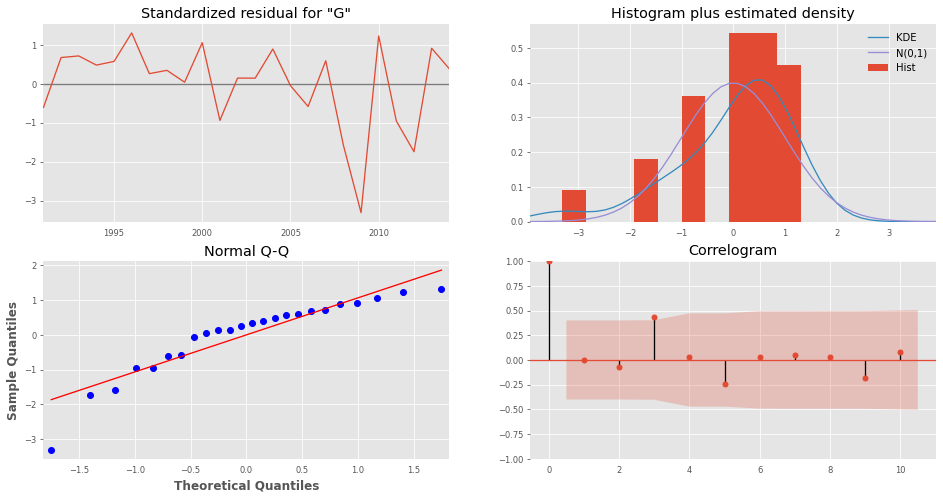

In [201]:
model_fit3.plot_diagnostics(figsize=(16, 8))
plt.show()

##### Our metrics (P values, AIC score) do not show a promising model. We might not have enough data. We also have not accounted for trends and residuals. 

##### Let's try a non-differenced gridsearch, Auto-ARIMA with a train/test split. 


In [202]:
df2DT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 1991-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GHGS_USA  24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes


In [203]:
arima_model4 = auto_arima(df2, start_p=0, d=1, start_q=0, max_p=10, max_d=5, max_q=5,
                        start_P=0, D=0, start_Q=0, max_P=5, max_D=5,
                        max_Q=5, m=1, seasonal=False, error_action='warn',
                        trace=True, suprress_warnings=True, stepwise=True, random_state=20,
                        n_fits=50)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=644.327, BIC=646.683, Time=0.015 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=645.990, BIC=649.524, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=646.267, BIC=649.801, Time=0.050 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=642.756, BIC=643.934, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=648.712, BIC=653.424, Time=0.120 seconds
Total fit time: 0.220 seconds


In [204]:
arima_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -320.378
Date:                Thu, 29 Apr 2021   AIC                            642.756
Time:                        12:05:11   BIC                            643.934
Sample:                             0   HQIC                           643.069
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.21e+10   5.17e+09      4.273      0.000     1.2e+10    3.22e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 8.91
Prob(Q):                              0.88   Prob(JB):                         0.01
Heteroskedasticity (H):               3.99   Skew:                            -1.29
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [205]:
model5 = ARIMA(df2, order=(0,1,0))
model_fit5 = model5.fit()
print(model_fit5.summary())

                               SARIMAX Results                                
Dep. Variable:               GHGS_USA   No. Observations:                   25
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -320.378
Date:                Thu, 29 Apr 2021   AIC                            642.756
Time:                        12:05:11   BIC                            643.934
Sample:                    01-01-1990   HQIC                           643.069
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.21e+10   5.17e+09      4.273      0.000     1.2e+10    3.22e+10
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 8.91
Prob(Q):                              0.88   Pr

predicted=7316144.455928, expected=7422207.962951
predicted=7422207.962951, expected=7216415.070902
predicted=7216415.070902, expected=6776229.773877
predicted=6776229.773877, expected=6985457.053427
predicted=6985457.053427, expected=6865397.902999
predicted=6865397.902999, expected=6643010.577873
predicted=6643010.577873, expected=6799979.302801
predicted=6799979.302801, expected=6870446.091538
Test RMSE: 219264.225


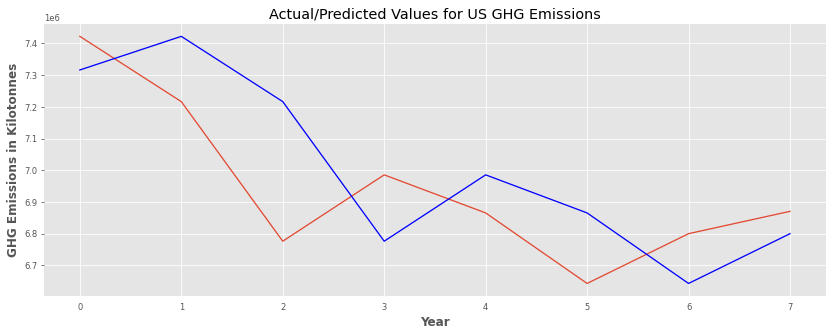

In [206]:
X = df2.values
size = int(len(X) * .7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='blue')
pyplot.title('Actual/Predicted Values for US GHG Emissions')
pyplot.ylabel('GHG Emissions in Kilotonnes')
pyplot.xlabel('Year')
pyplot.show()

### US GHG ARIMA Conclusion
##### Regardless of our approach to the dataset, whether any data is held for training, it seems we do not have enough data.  
    - AIC scores are in the 600s
    - MSE and RMSE are both astronomically high 
    